# 🤖 불균형 분류 모델링

## 목표: SMOTE + Tomek Links와 앙상블 기법으로 부도 예측 모델 구축

이 노트북에서는:
- SMOTE + Tomek Links로 불균형 처리
- Focal Loss 등 커스텀 손실 함수
- LightGBM, XGBoost, CatBoost 앙상블
- Stratified K-Fold 교차 검증

## 0. 라이브러리 및 설정

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
import time


# Scikit-learn & Evaluation
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import (
    average_precision_score, roc_auc_score, classification_report, 
    precision_recall_curve, f1_score
)
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import confusion_matrix, precision_recall_curve, auc

# Imbalanced Learn
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from imblearn.under_sampling import TomekLinks, RandomUnderSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedRandomForestClassifier

# Boosting Models
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px


import matplotlib.patches as patches
# 폰트 설정
import platform
if platform.system() == 'Darwin': plt.rc('font', family='AppleGothic')
elif platform.system() == 'Windows': plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)

print("✅ 환경 설정 완료")

✅ 환경 설정 완료


## 1. 전처리 클래스 정의

In [2]:
# 1. 무한대(inf) 처리
class InfiniteHandler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        return X.replace([np.inf, -np.inf], np.nan)

# 2. Winsorization (이상치 제어)
class Winsorizer(BaseEstimator, TransformerMixin):
    def __init__(self, lower_quantile=0.01, upper_quantile=0.99):
        self.lower_quantile = lower_quantile
        self.upper_quantile = upper_quantile
        self.lower_limits_ = None
        self.upper_limits_ = None
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            self.lower_limits_ = X.quantile(self.lower_quantile)
            self.upper_limits_ = X.quantile(self.upper_quantile)
        else:
            self.lower_limits_ = np.quantile(X, self.lower_quantile, axis=0)
            self.upper_limits_ = np.quantile(X, self.upper_quantile, axis=0)
        return self
    def transform(self, X):
        X = X.copy()
        if isinstance(X, pd.DataFrame):
            return X.clip(lower=self.lower_limits_, upper=self.upper_limits_, axis=1)
        return np.clip(X, self.lower_limits_, self.upper_limits_)

# 3. 로그 변환
class LogTransformer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None): return self
    def transform(self, X):
        X = X.copy()
        numeric_cols = X.select_dtypes(include=[np.number]).columns
        for col in numeric_cols:
            if (X[col] > 0).all():
                X[col] = np.log1p(X[col])
        return X

print("✅ 전처리 클래스 정의 완료")

✅ 전처리 클래스 정의 완료


# 2. 데이터 로드 및 분할

In [3]:
# 데이터 로드
df = pd.read_csv('../data/processed/selected_features.csv', encoding='utf-8-sig')
target_col = '모형개발용Performance(향후1년내부도여부)'

X = df.drop(columns=[target_col])
y = df[target_col]

# 1. Train/Test 분리 (Leakage 방지 최우선)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"학습 세트: {X_train.shape} (부도율: {y_train.mean():.2%})")
print(f"테스트 세트: {X_test.shape} (부도율: {y_test.mean():.2%})")

# 2. 전처리 파이프라인 (ImbPipeline 사용 금지 - 단순 전처리용)
from sklearn.pipeline import Pipeline
preprocessing_pipeline = Pipeline([
    ('inf', InfiniteHandler()),
    ('winsor', Winsorizer()),
    ('log', LogTransformer()),
    ('imp', IterativeImputer(max_iter=10, random_state=42)),
    ('scl', RobustScaler())
])

print("✅ 데이터 준비 완료")

학습 세트: (40084, 35) (부도율: 1.51%)
테스트 세트: (10021, 35) (부도율: 1.52%)
✅ 데이터 준비 완료


## 3. 단일 모델 선정 파이프라인

In [4]:
print("🚀 [AutoML] 리샘플링(4종) x 모델(5종) x 가중치 전략 통합 튜닝 시작...")
start_time = time.time()
# Stratified K-Fold 객체 생성 (5-Fold, 시드 고정)
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 1. 통합 파이프라인 (ImbPipeline) - 구조 평탄화
pipeline = ImbPipeline([
    # --- 전처리 ---
    ('inf_handler', InfiniteHandler()),
    ('winsorizer', Winsorizer(lower_quantile=0.01, upper_quantile=0.99)),
    ('log_transformer', LogTransformer()),
    ('imputer', IterativeImputer(max_iter=10, random_state=42)),
    ('scaler', RobustScaler()),
    # ------------
    ('resampler', 'passthrough'),
    ('classifier', LogisticRegression())
])

# 2. 가중치 계산
neg, pos = np.bincount(y_train)
scale_ratio = neg / pos # 약 66
sqrt_ratio = np.sqrt(scale_ratio) # 약 8.1

# 3. 리샘플링 후보군 (언더샘플링 추가)
resampler_list = [
    'passthrough',
    SMOTE(sampling_strategy=0.2, random_state=42), # 과생성 방지 0.2
    BorderlineSMOTE(sampling_strategy=0.2, random_state=42),
    RandomUnderSampler(sampling_strategy=0.3, random_state=42) # 언더샘플링
]

# 4. 검색 공간 (모델 다양성 & 규제 강화)
param_grid = [
    # 1-A. LightGBM (자동 밸런싱 + 과적합 방지 파라미터 추가)
    {
        'resampler': resampler_list,
        'classifier': [lgb.LGBMClassifier(random_state=42, verbose=-1)],
        'classifier__n_estimators': [300, 500, 1000],       # 트리 개수 늘림
        'classifier__learning_rate': [0.01, 0.02, 0.05],    # 학습률 세분화
        'classifier__num_leaves': [31, 63, 127],            # 트리의 복잡도
        'classifier__max_depth': [-1, 10, 20],              # 트리의 깊이 제한
        'classifier__min_child_samples': [20, 50],          # 리프 노드 최소 데이터 수
        'classifier__subsample': [0.7, 0.9],                # 데이터 샘플링 비율
        'classifier__colsample_bytree': [0.7, 0.9],         # 컬럼 샘플링 비율
        'classifier__reg_alpha': [0.1, 0.5],                # L1 규제
        'classifier__reg_lambda': [0.1, 0.5],               # L2 규제
        'classifier__is_unbalance': [True],
        'classifier__scale_pos_weight': [1]
    },
    # 1-B. LightGBM (수동 가중치) - 위와 동일한 파라미터 확장 적용
    {
        'resampler': resampler_list,
        'classifier': [lgb.LGBMClassifier(random_state=42, verbose=-1)],
        'classifier__n_estimators': [300, 500],
        'classifier__learning_rate': [0.01, 0.03],
        'classifier__num_leaves': [31, 63],
        'classifier__subsample': [0.8, 1.0],
        'classifier__reg_alpha': [0.1],
        'classifier__is_unbalance': [False],
        'classifier__scale_pos_weight': [1, sqrt_ratio, 20] # 가중치 실험 유지
    },
    # 2. XGBoost (규제 및 샘플링 파라미터 추가)
    {
        'resampler': resampler_list,
        'classifier': [xgb.XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False)],
        'classifier__n_estimators': [300, 500],
        'classifier__max_depth': [4, 6, 8],                 # 깊이 다양화
        'classifier__learning_rate': [0.01, 0.05],          # 학습률 추가
        'classifier__gamma': [0, 0.1, 0.5],                 # 가지치기 규제
        'classifier__subsample': [0.7, 0.9],                # 과적합 방지
        'classifier__colsample_bytree': [0.7, 0.9],
        'classifier__reg_alpha': [0.1, 1.0],
        'classifier__scale_pos_weight': [1, sqrt_ratio, scale_ratio]
    },
    # 3. CatBoost (깊이와 정규화 파라미터 확장)
    {
        'resampler': resampler_list,
        'classifier': [CatBoostClassifier(random_state=42, verbose=0, allow_writing_files=False)],
        'classifier__iterations': [500, 1000],
        'classifier__learning_rate': [0.01, 0.03, 0.1],
        'classifier__loss_function': ['Logloss', 'Focal:alpha=0.25;gamma=2.0'],
        'classifier__depth': [4, 6, 8],                     # 깊이 증가
        'classifier__l2_leaf_reg': [3, 5, 9],               # 정규화 강도 다양화
        'classifier__bagging_temperature': [0, 1],          # 배깅 강도
        'classifier__auto_class_weights': ['Balanced', 'SqrtBalanced']
    },
    # 4. Balanced Random Forest (트리 개수 및 깊이 확장)
    {
        'resampler': resampler_list,
        'classifier': [BalancedRandomForestClassifier(random_state=42, n_jobs=-1)],
        'classifier__n_estimators': [300, 500],
        'classifier__max_depth': [10, 20, None],            # 깊이 제한 해제 포함
        'classifier__min_samples_leaf': [2, 4],
        'classifier__max_features': ['sqrt', 'log2']        # 피처 선택 방식
    },
    # 5. Logistic Regression (베이스라인)
    {
        'resampler': resampler_list,
        'classifier': [LogisticRegression(random_state=42, solver='lbfgs', max_iter=1000)],
        'classifier__C': [0.1, 1.0, 10.0],
        'classifier__class_weight': ['balanced', None]
    }
]

# 5. 최적화 실행 설정 변경
search = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_grid,
    n_iter=100,                  # 💡 중요: 기존 30에서 50~100으로 증가 (탐색 횟수 증가)
    scoring='average_precision', # 불균형 데이터이므로 PR-AUC 유지 추천
    cv=skf,                      
    n_jobs=-1,
    verbose=1,
    random_state=42
)

search.fit(X_train, y_train)
best_single_model = search.best_estimator_

print(f"\n✅ 단일 모델 최적화 완료 (소요시간: {time.time() - start_time:.1f}초)")
print(f"🏆 Best Single Model: {search.best_params_['classifier'].__class__.__name__}")
print(f"   - Resampler: {search.best_params_['resampler']}")
print(f"   - Params: {search.best_params_}")

🚀 [AutoML] 리샘플링(4종) x 모델(5종) x 가중치 전략 통합 튜닝 시작...
Fitting 5 folds for each of 100 candidates, totalling 500 fits

✅ 단일 모델 최적화 완료 (소요시간: 1744.8초)
🏆 Best Single Model: XGBClassifier
   - Resampler: passthrough
   - Params: {'resampler': 'passthrough', 'classifier__subsample': 0.9, 'classifier__scale_pos_weight': 1, 'classifier__reg_alpha': 0.1, 'classifier__n_estimators': 500, 'classifier__max_depth': 6, 'classifier__learning_rate': 0.01, 'classifier__gamma': 0.1, 'classifier__colsample_bytree': 0.7, 'classifier': XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_c

## 4. AutoML 결과 기반 Top 3 가중치(Weighted) 앙상블 구축

In [5]:
from sklearn.ensemble import VotingClassifier
from sklearn.base import clone

print("\n🔄 [Step 2] AutoML 상위 모델 기반 Weighted Voting 구축...")

# 1. AutoML 결과 분석
results_df = pd.DataFrame(search.cv_results_)
# PR-AUC 점수순으로 정렬하여 상위 3개 추출
top3_results = results_df.sort_values(by='mean_test_score', ascending=False).head(3)

ensemble_estimators = []
ensemble_weights = []

print(f"   👉 상위 3개 모델 선정 및 가중치 계산:")

# 2. Top 3 모델 복원 및 가중치 할당
for i, (index, row) in enumerate(top3_results.iterrows()):
    # 파이프라인 복제 (기본 껍데기)
    pipe_clone = clone(pipeline)
    
    # 찾은 최적 파라미터 주입
    pipe_clone.set_params(**row['params'])
    
    # 모델 이름 및 가중치 설정
    # 가중치는 검증 점수(PR-AUC)를 그대로 사용 (성능 좋을수록 발언권 셈)
    # 격차를 더 벌리고 싶다면 row['mean_test_score'] ** 2 를 사용해도 됨
    score = row['mean_test_score']
    model_name = f"Top{i+1}_{row['param_classifier'].__class__.__name__}"
    
    ensemble_estimators.append((model_name, pipe_clone))
    ensemble_weights.append(score)
    
    print(f"      {i+1}. {model_name:<20} | CV Score: {score:.4f} (Weight)")

# 3. Weighted Soft Voting 모델 정의
# 파이프라인 자체가 분류기로 들어가므로 전처리+리샘플링+예측이 각자 수행됨
voting_clf = VotingClassifier(
    estimators=ensemble_estimators,
    voting='soft',
    weights=ensemble_weights, # 여기가 핵심! (성능 기반 가중치)
    n_jobs=-1
)

# 4. 앙상블 학습
print(f"\n   👉 Weighted Ensemble 학습 시작...")
voting_clf.fit(X_train, y_train)
print("✅ 학습 완료")


🔄 [Step 2] AutoML 상위 모델 기반 Weighted Voting 구축...
   👉 상위 3개 모델 선정 및 가중치 계산:
      1. Top1_XGBClassifier   | CV Score: 0.1668 (Weight)
      2. Top2_LGBMClassifier  | CV Score: 0.1559 (Weight)
      3. Top3_LGBMClassifier  | CV Score: 0.1546 (Weight)

   👉 Weighted Ensemble 학습 시작...
✅ 학습 완료


## 6. 최종 결승전: Single Best vs Weighted Ensemble

In [6]:
print("\n🔄 [Step 3] 최종 성능 비교 (Test Set 평가)")

def get_scores(model_name, model, X, y):
    y_prob = model.predict_proba(X)[:, 1]
    return {
        'Model': model_name,
        'PR-AUC': average_precision_score(y, y_prob),
        'ROC-AUC': roc_auc_score(y, y_prob),
        'F1-Score': f1_score(y, (y_prob >= 0.5).astype(int))
    }

# 점수 계산
scores = []
# 1. Single Best
scores.append(get_scores("1. Single Best", best_single_model, X_test, y_test))
# 2. Weighted Voting
scores.append(get_scores("2. Weighted Voting", voting_clf, X_test, y_test))

# 결과 출력
result_df = pd.DataFrame(scores).set_index('Model').sort_values('PR-AUC', ascending=False)
print("\n📊 모델 성능 비교표 (PR-AUC 기준)")
print("=" * 60)
print(result_df)
print("=" * 60)

# 승자 결정 로직
winner = result_df.index[0]
winner_score = result_df.iloc[0]['PR-AUC']
runner_up_score = result_df.iloc[1]['PR-AUC']

# 앙상블은 복잡도가 높으므로, 단일 모델보다 유의미하게(예: 0.5% 이상) 좋아야 선택
if "Voting" in winner and (winner_score > runner_up_score * 1.005):
    final_model = voting_clf
    final_model_name = "Weighted_Voting_Ensemble"
    print(f"\n🏆 우승 모델: [Weighted Voting] (단일 모델보다 성능 우위 확인)")
else:
    # 점수가 비슷하거나 단일 모델이 더 좋으면 단일 모델 선택 (유지보수 용이성)
    final_model = best_single_model
    final_model_name = f"Single_{search.best_params_['classifier'].__class__.__name__}"
    print(f"\n🏆 우승 모델: [Single Best] (성능 차이가 미미하거나 더 우수함)")

print(f"✅ Final Model이 '{final_model_name}'으로 확정되었습니다.")


🔄 [Step 3] 최종 성능 비교 (Test Set 평가)

📊 모델 성능 비교표 (PR-AUC 기준)
                      PR-AUC   ROC-AUC  F1-Score
Model                                           
1. Single Best      0.145141  0.891356  0.012821
2. Weighted Voting  0.135236  0.876589  0.248848

🏆 우승 모델: [Single Best] (성능 차이가 미미하거나 더 우수함)
✅ Final Model이 'Single_XGBClassifier'으로 확정되었습니다.


In [8]:
def plot_feature_importance_kr(model, feature_names):
    # 파이프라인 등에서 최종 모델 추출
    if hasattr(model, 'named_steps'):
        classifier = model.named_steps['classifier']
    else:
        classifier = model

    # 중요도 추출 가능 여부 확인
    if hasattr(classifier, 'feature_importances_'):
        importances = classifier.feature_importances_
        
        # 데이터프레임 생성
        fi_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
        fi_df = fi_df.sort_values(by='Importance', ascending=True).tail(15) # 상위 15개

        fig = px.bar(fi_df, x='Importance', y='Feature', orientation='h',
                     title='<b>핵심 위험 요인 TOP 15 (변수 중요도)</b>',
                     text_auto='.3f',
                     color='Importance', color_continuous_scale='Blues')
        
        fig.update_layout(
            height=600, 
            template='plotly_white',
            xaxis_title="중요도 점수 (Importance Score)",
            yaxis_title="재무 지표 (Feature)",
            font=dict(family="Malgun Gothic", size=14) # 폰트 설정
        )
        fig.show()
    else:
        print("⚠️ 이 모델(Voting 등)은 변수 중요도를 직접 추출할 수 없습니다.")

print("\n📊 [Visual 1] 핵심 변수 중요도 시각화")
# X_test의 컬럼명이 살아있다고 가정하고 실행
plot_feature_importance_kr(final_model, X_test.columns)


# -------------------------------------------------------
# 2. 예측 확률 분포 (Prediction Distribution) - 한글화
# -------------------------------------------------------
y_prob = final_model.predict_proba(X_test)[:, 1]

def plot_probability_distribution_kr(y_true, y_prob):
    df_dist = pd.DataFrame({'Truth': y_true, 'Probability': y_prob})
    
    # 0(정상)과 1(부도) 분리
    hist_data_0 = df_dist[df_dist['Truth'] == 0]['Probability']
    hist_data_1 = df_dist[df_dist['Truth'] == 1]['Probability']

    fig = go.Figure()
    
    # 정상 기업 분포 (초록색)
    fig.add_trace(go.Histogram(
        x=hist_data_0, name='정상 기업 (0)',
        marker_color='green', opacity=0.6, nbinsx=100, histnorm='percent'
    ))
    
    # 부도 기업 분포 (빨간색)
    fig.add_trace(go.Histogram(
        x=hist_data_1, name='부도 기업 (1)',
        marker_color='red', opacity=0.6, nbinsx=100, histnorm='percent'
    ))

    fig.update_layout(
        title='<b>모델 변별력: 정상 vs 부도 기업 예측 확률 분포</b>',
        xaxis_title='부도 예측 확률 (Predicted Probability)',
        yaxis_title='기업 비율 (%, 로그 스케일)',
        barmode='overlay',
        template='plotly_white',
        height=500,
        font=dict(family="Malgun Gothic", size=14)
    )
    # 로그 스케일 적용 (불균형 데이터 시각화 필수)
    fig.update_yaxes(type="log")
    
    fig.show()

print("\n📊 [Visual 2] 예측 확률 분포 시각화")
plot_probability_distribution_kr(y_test, y_prob)


# -------------------------------------------------------
# 3. 모델 성능 비교 (AutoML Results) - 한글화 & 오류 수정
# -------------------------------------------------------
def plot_model_comparison_kr(search_obj):
    # 오류 방지: cv_results_ 속성이 있는지 먼저 확인
    if not hasattr(search_obj, 'cv_results_'):
        print("⚠️ 'search' 객체에 학습 결과(cv_results_)가 없습니다.")
        print("   (이유: search.fit()이 실행되지 않았거나, search가 모델 자체일 수 있습니다.)")
        return

    # 결과 데이터프레임화
    res_df = pd.DataFrame(search_obj.cv_results_)
    
    # 모델 이름 추출
    res_df['Model_Name'] = res_df['param_classifier'].apply(lambda x: x.__class__.__name__)
    
    # 모델별 최고 점수 집계
    best_scores = res_df.groupby('Model_Name')['mean_test_score'].max().sort_values()
    
    fig = px.bar(
        x=best_scores.values, 
        y=best_scores.index, 
        orientation='h',
        title='<b>모델별 성능 비교 (AutoML 검증 점수)</b>',
        text_auto='.4f',
        color=best_scores.values,
        color_continuous_scale='Teal'
    )
    
    fig.update_layout(
        xaxis_title="평균 검증 점수 (PR-AUC Score)",
        yaxis_title="모델 유형",
        template='plotly_white',
        showlegend=False,
        font=dict(family="Malgun Gothic", size=14)
    )
    # 여백 확보
    fig.update_xaxes(range=[0, max(best_scores.values)*1.2]) 
    
    fig.show()

print("\n📊 [Visual 3] 모델 성능 비교 시각화")
# search 변수가 존재할 때만 실행 (오류 방지 로직 적용됨)
if 'search' in locals():
    plot_model_comparison_kr(search)
else:
    print("⚠️ 'search' 변수가 메모리에 없어 건너뜁니다.")


# -------------------------------------------------------
# 4. 효율성 분석 (Cumulative Gain) - 한글화
# -------------------------------------------------------
def plot_cumulative_gain_kr(y_true, y_prob):
    # 데이터 정렬
    df = pd.DataFrame({'y': y_true, 'prob': y_prob})
    df = df.sort_values(by='prob', ascending=False).reset_index(drop=True)
    
    # 누적 계산
    df['cum_pos'] = df['y'].cumsum()
    total_pos = df['y'].sum()
    
    # Gain(이득) 및 비율 계산
    df['gain'] = df['cum_pos'] / total_pos
    df['percentage'] = (df.index + 1) / len(df)
    
    fig = go.Figure()
    
    # 모델 성능 곡선
    fig.add_trace(go.Scatter(x=df['percentage'], y=df['gain'], mode='lines', 
                             name='우리 모델', line=dict(color='blue', width=3)))
    
    # 랜덤 기준선 (Base Line)
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1], mode='lines', 
                             name='랜덤 선택 (기준)', line=dict(dash='dash', color='gray')))
    
    # 강조 주석 (상위 20% 지점)
    top_n = 0.2
    gain_at_n = df.loc[int(len(df)*top_n), 'gain']
    
    fig.add_annotation(
        x=top_n, y=gain_at_n,
        text=f"<b>상위 {top_n*100}% 심사 시</b><br>▼<br><b>실제 부도의 {gain_at_n*100:.1f}% 포착</b>",
        showarrow=True, arrowhead=2, ax=60, ay=30,
        font=dict(color='red', size=12),
        align="center",
        bgcolor="rgba(255, 255, 255, 0.8)"
    )

    fig.update_layout(
        title='<b>심사 효율성 분석 (Cumulative Gains Curve)</b>',
        xaxis_title='상위 N% 기업 (위험도 순)',
        yaxis_title='부도 포착 비율 (누적)',
        template='plotly_white',
        xaxis=dict(tickformat='.0%'),
        yaxis=dict(tickformat='.0%'),
        font=dict(family="Malgun Gothic", size=14)
    )
    fig.show()

print("\n📊 [Visual 4] 효율성 분석 시각화")
plot_cumulative_gain_kr(y_test, y_prob)


📊 [Visual 1] 핵심 변수 중요도 시각화



📊 [Visual 2] 예측 확률 분포 시각화



📊 [Visual 3] 모델 성능 비교 시각화



📊 [Visual 4] 효율성 분석 시각화


In [9]:
def plot_performance_dashboard(y_true, y_score, threshold=0.05):
    # 1. 데이터 계산
    y_pred = (y_score >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    pr_auc = auc(recall, precision)

    # 2. 서브플롯 생성
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=(f"<b>Confusion Matrix (Cut-off: {threshold})</b>", 
                        f"<b>PR-AUC Curve (AUC: {pr_auc:.3f})</b>"),
        horizontal_spacing=0.15
    )

    # 3. Confusion Matrix (Heatmap)
    # 의료 통계처럼 [TN, FP / FN, TP] 구조가 아니라 sklearn은 [[TN, FP], [FN, TP]]임
    # 시인성을 위해 텍스트를 명확히 표기
    z_text = [[f"TN: {cm[0][0]}<br>(정상 분류)", f"FP: {cm[0][1]}<br>(오탐지)"],
              [f"FN: {cm[1][0]}<br>(미탐지)", f"TP: {cm[1][1]}<br>(부도 포착)"]]

    fig.add_trace(go.Heatmap(
        z=cm, x=['Predicted Normal', 'Predicted Default'], y=['Actual Normal', 'Actual Default'],
        text=z_text, texttemplate="%{text}",
        colorscale='Blues', showscale=False
    ), row=1, col=1)

    # 4. PR Curve
    fig.add_trace(go.Scatter(
        x=recall, y=precision, mode='lines', name='PR Curve',
        line=dict(color='#2C3E50', width=3), fill='tozeroy'
    ), row=1, col=2)

    # 현재 임계값 위치 표시 (Red Dot)
    current_idx = np.argmin(np.abs(thresholds - threshold))
    fig.add_trace(go.Scatter(
        x=[recall[current_idx]], y=[precision[current_idx]],
        mode='markers+text', name='Current Threshold',
        marker=dict(color='red', size=12, symbol='circle-open-dot', line=dict(width=2)),
        text=[f"Th={threshold}"], textposition="top right"
    ), row=1, col=2)

    # 5. 레이아웃 다듬기
    fig.update_layout(
        title_text="<b>Model Performance Overview</b>",
        height=500, width=1000,
        template='plotly_white',
        font=dict(family="Arial", size=14)
    )
    
    # PR Curve 축 라벨
    fig.update_xaxes(title_text="Recall (재현율)", row=1, col=2)
    fig.update_yaxes(title_text="Precision (정밀도)", row=1, col=2)

    fig.show()

# 위험 임계값(Red)인 0.05를 기준으로 성능 평가
plot_performance_dashboard(y_test, y_prob, threshold=0.05)

📊 모델 전체 성능 (PR-AUC): 0.1413 (Threshold와 무관한 고정값)
🎯 최적 Threshold (Max F1): 0.0811
   - F1 Score: 0.2693
   - Precision: 0.2027
   - Recall:    0.4013


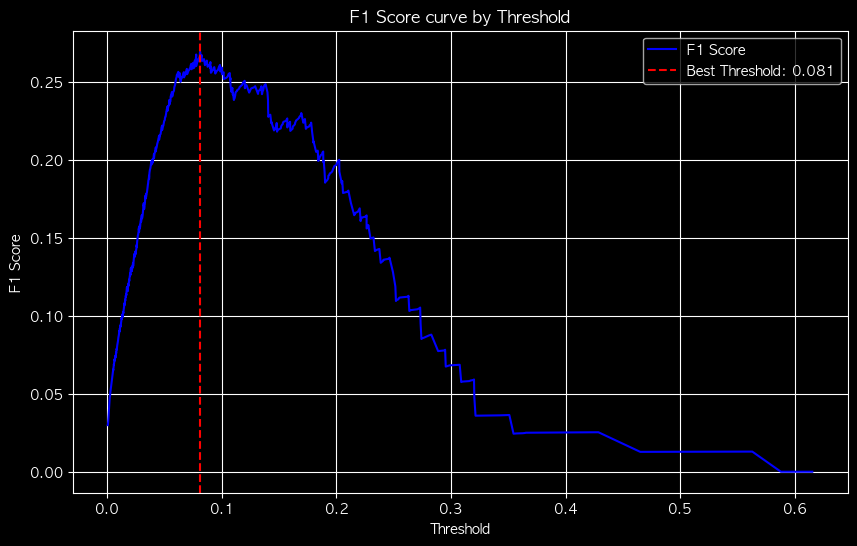

In [10]:
def find_optimal_threshold_by_f1(y_true, y_prob):
    # 1. PR Curve 계산 (모든 가능한 threshold에 대해 P, R 계산)
    precisions, recalls, thresholds = precision_recall_curve(y_true, y_prob)
    
    # 2. PR-AUC 계산 (모델 자체의 성능 평가 지표)
    pr_auc = auc(recalls, precisions)
    
    # 3. F1 Score 계산 (분모가 0이 되는 경우 방지)
    numerator = 2 * precisions * recalls
    denominator = precisions + recalls
    f1_scores = np.divide(numerator, denominator, out=np.zeros_like(numerator), where=denominator!=0)
    
    # 4. 최적 Threshold 찾기 (F1 Score가 최대인 지점)
    # thresholds 배열은 precisions보다 길이가 1 짧으므로 마지막 인덱스 제외 처리 필요할 수 있음
    max_f1_idx = np.argmax(f1_scores)
    best_threshold = thresholds[max_f1_idx]
    best_f1 = f1_scores[max_f1_idx]
    best_precision = precisions[max_f1_idx]
    best_recall = recalls[max_f1_idx]
    
    print(f"📊 모델 전체 성능 (PR-AUC): {pr_auc:.4f} (Threshold와 무관한 고정값)")
    print(f"🎯 최적 Threshold (Max F1): {best_threshold:.4f}")
    print(f"   - F1 Score: {best_f1:.4f}")
    print(f"   - Precision: {best_precision:.4f}")
    print(f"   - Recall:    {best_recall:.4f}")
    
    return best_threshold, precisions, recalls, f1_scores, thresholds

# -------------------------------------------------------
# 사용 예시 (이전에 로드된 y_test, y_prob 사용)
# -------------------------------------------------------
if 'y_test' in locals() and 'y_prob' in locals():
    best_th, precisions, recalls, f1_scores, thresholds = find_optimal_threshold_by_f1(y_test, y_prob)

    # 시각화: Threshold 변화에 따른 F1 Score 변화
    plt.figure(figsize=(10, 6))
    plt.plot(thresholds, f1_scores[:-1], label='F1 Score', color='blue')
    plt.axvline(best_th, color='red', linestyle='--', label=f'Best Threshold: {best_th:.3f}')
    
    plt.title('F1 Score curve by Threshold')
    plt.xlabel('Threshold')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.grid(True)
    plt.show()

## 7. 신호등 시스템 적용

In [11]:

# 1. 데이터 준비
y_prob = final_model.predict_proba(X_test)[:, 1]  
# 히스토그램 데이터를 먼저 계산 (그래프 커스터마이징을 위해)
counts, bin_edges = np.histogram(y_prob, bins=150, range=(0, 0.2))
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

# 2. 그래프 생성
fig = go.Figure()

# 영역 채우기 (Step Plot)
fig.add_trace(go.Scatter(
    x=bin_centers, 
    y=counts,
    mode='lines', 
    line=dict(width=1, color='skyblue'), 
    fill='tozeroy', 
    name='기업 수',
    opacity=0.6, 
    line_shape='hv'
))

# 3. 레이아웃 설정 (로그 스케일)
fig.update_layout(
    title='<b>부도 예측 확률 분포 및 리스크 등급 (Log Scale)</b>',
    xaxis_title='부도 예측 확률 (Probability)',
    yaxis_title='기업 수 (Count, Log Scale)',
    yaxis_type="log",
    template='plotly_white',
    showlegend=False,
    height=600,
    margin=dict(r=150) # 💡 오른쪽 여백 추가 (글씨 짤림 방지)
)

# 축 범위 설정
fig.update_xaxes(range=[0, 0.2])
fig.update_yaxes(range=[0, 4.5]) 

# 4. 임계값 선 추가
fig.add_vline(x=0.02, line_width=2, line_dash="dot", line_color="#FFD700")
fig.add_vline(x=0.05, line_width=2, line_dash="dot", line_color="red")

# 5. 텍스트 및 화살표 설정 (💡 핵심 수정 구간)

# (1) Yellow: 높이(y)를 '높게(1000)' 설정
fig.add_annotation(
    x=0.02, y=3,             # y=3은 로그스케일에서 10^3 = 1000 위치
    text="<b>관찰 구간 (상위 15%)</b>",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,             # 💡 화살표 크기 축소 (기본값보다 작게)
    arrowwidth=1,            # 화살표 두께 얇게
    ax=40, ay=0,             # 화살표 길이 (픽셀 단위)
    xanchor="left",
    font=dict(size=12, color="#DAA520"),
    align="left"
)

# (2) Red: 높이(y)를 '낮게(10)' 설정 -> 겹침 방지
fig.add_annotation(
    x=0.05, y=1,             # y=1은 로그스케일에서 10^1 = 10 위치 (훨씬 아래)
    text="<b>위험 구간 (상위 5%)</b>",
    showarrow=True,
    arrowhead=2,
    arrowsize=1,             # 💡 화살표 크기 축소
    arrowwidth=1,
    ax=40, ay=0,
    xanchor="left",
    font=dict(size=12, color="red"),
    align="left"
)

# (3) 상단 레이블 (선 이름)
fig.add_annotation(x=0.02, y=4.6, text="Yellow (0.02)", showarrow=False, font=dict(color="#FFD700", size=11))
fig.add_annotation(x=0.05, y=4.6, text="Red (0.05)", showarrow=False, font=dict(color="red", size=11))

fig.show()

In [12]:
print("\n[Step 4] 신호등 시스템 (임계값 조정 버전) 적용")

# 💡 수정 포인트: 임계값을 0.3/0.6에서 대폭 낮춤 (예: 0.05 / 0.1)
# 이는 모델의 예측 확률이 전반적으로 낮기 때문입니다.
def run_traffic_light_v2(model, X, y, y_th=0.05, r_th=0.1):
    y_prob = model.predict_proba(X)[:, 1]
    
    conditions = [(y_prob >= r_th), (y_prob >= y_th)]
    choices = ['3.Red(위험)', '2.Yellow(관찰)']
    grades = np.select(conditions, choices, default='1.Green(정상)')
    
    df_res = pd.DataFrame({'Actual': y, 'Grade': grades, 'Prob': y_prob})
    
    print(f"\n🚦 등급별 현황 (임계값: Y>={y_th}, R>={r_th})")
    print("="*60)
    # 등급 순서: Red -> Yellow -> Green
    grade_order = ['3.Red(위험)', '2.Yellow(관찰)', '1.Green(정상)']
    
    for g in grade_order:
        sub = df_res[df_res['Grade']==g]
        cnt = len(sub)
        ratio = cnt / len(df_res) * 100
        defs = sub['Actual'].sum()
        prec = defs / cnt if cnt > 0 else 0
        
        # 실제 부도 중 해당 등급이 차지하는 비중 (Recall 기여도)
        total_defs = df_res['Actual'].sum()
        recall_contribution = defs / total_defs * 100 if total_defs > 0 else 0
        
        print(f"[{g}] 기업수: {cnt:>5} ({ratio:>4.1f}%) | 실제부도: {defs:>3} | 적중률(Precision): {prec*100:.1f}% | 부도포착(Recall): {recall_contribution:.1f}%")
    
    # 방어율 통합 계산
    total_def = df_res['Actual'].sum()
    caught_def = df_res[df_res['Grade'] != '1.Green(정상)']['Actual'].sum()
    print("-" * 60)
    print(f"🛡️ 리스크 방어율(Total Recall): {caught_def/total_def*100:.1f}% ({caught_def}/{total_def})")

# 변경된 임계값으로 실행 (예시: 0.05 이상이면 관찰, 0.1 이상이면 위험)
run_traffic_light_v2(final_model, X_test, y_test, y_th=0.02, r_th=0.05)


[Step 4] 신호등 시스템 (임계값 조정 버전) 적용

🚦 등급별 현황 (임계값: Y>=0.02, R>=0.05)
[3.Red(위험)] 기업수:   496 ( 4.9%) | 실제부도:  73 | 적중률(Precision): 14.7% | 부도포착(Recall): 48.0%
[2.Yellow(관찰)] 기업수:  1068 (10.7%) | 실제부도:  36 | 적중률(Precision): 3.4% | 부도포착(Recall): 23.7%
[1.Green(정상)] 기업수:  8457 (84.4%) | 실제부도:  43 | 적중률(Precision): 0.5% | 부도포착(Recall): 28.3%
------------------------------------------------------------
🛡️ 리스크 방어율(Total Recall): 71.7% (109/152)


In [13]:
def plot_traffic_light_system(y_true, y_score):
    # 1. 등급 산정 로직 (노트북 기준)
    # Green(<0.02), Yellow(0.02~0.05), Red(>=0.05)
    conditions = [
        (y_score < 0.02),
        (y_score >= 0.02) & (y_score < 0.05),
        (y_score >= 0.05)
    ]
    choices = ['Green (Safe)', 'Yellow (Watch)', 'Red (Danger)']
    grades = np.select(conditions, choices)

    # 데이터프레임 생성
    df_risk = pd.DataFrame({'Grade': grades, 'Actual': y_true})
    
    # 요약 통계 계산
    summary = df_risk.groupby('Grade').agg(
        Count=('Actual', 'count'),
        Defaults=('Actual', 'sum')
    ).reindex(['Green (Safe)', 'Yellow (Watch)', 'Red (Danger)']) # 순서 고정
    
    summary['Default_Rate'] = (summary['Defaults'] / summary['Count']) * 100
    
    # 2. 시각화 (Donut + Bar)
    fig = make_subplots(
        rows=1, cols=2,
        column_widths=[0.4, 0.6],
        specs=[[{'type': 'domain'}, {'type': 'xy'}]], # 1번은 파이, 2번은 바
        subplot_titles=("<b>등급별 기업 비중 (Volume)</b>", "<b>등급별 실제 부도율 (Risk Check)</b>")
    )

    # 컬러 팔레트 (신호등 색상)
    colors = {'Green (Safe)': '#2ECC71', 'Yellow (Watch)': '#F1C40F', 'Red (Danger)': '#E74C3C'}
    color_list = [colors[g] for g in summary.index]

    # (1) Donut Chart: 기업 분포
    fig.add_trace(go.Pie(
        labels=summary.index, values=summary['Count'],
        marker=dict(colors=color_list),
        hole=0.5, sort=False,
        textinfo='label+percent',
        textfont=dict(size=13),
        showlegend=False
    ), row=1, col=1)

    # (2) Bar Chart: 등급별 부도율
    fig.add_trace(go.Bar(
        x=summary.index, y=summary['Default_Rate'],
        marker=dict(color=color_list),
        text=summary['Default_Rate'].apply(lambda x: f"{x:.1f}%"),
        textposition='auto',
        showlegend=False
    ), row=1, col=2)

    # 3. 레이아웃 설정
    fig.update_layout(
        title_text="<b>Early Warning System (Traffic Light)</b>",
        height=500, width=1000,
        template='plotly_white',
        font=dict(family="Arial", size=14)
    )
    
    fig.update_yaxes(title_text="실제 부도율 (%)", row=1, col=2)

    # Red 등급에 대한 강조 주석
    red_rate = summary.loc['Red (Danger)', 'Default_Rate']
    fig.add_annotation(
        x='Red (Danger)', y=red_rate,
        text="<b>High Risk!</b>",
        showarrow=True, arrowhead=2,
        ax=0, ay=-40,
        row=1, col=2,
        font=dict(color='#C0392B', size=12, weight='bold')
    )

    fig.show()

plot_traffic_light_system(y_test, y_prob)

## 8. 저장

In [14]:
import os
print("\n💾 모델 저장 중...")

save_dir = '../data/processed/'
os.makedirs(save_dir, exist_ok=True)

model_path = os.path.join(save_dir, 'final_bankruptcy_model.pkl')
joblib.dump(final_model, model_path)

print(f"✅ 저장 완료: {model_path}")


💾 모델 저장 중...
✅ 저장 완료: ../data/processed/final_bankruptcy_model.pkl


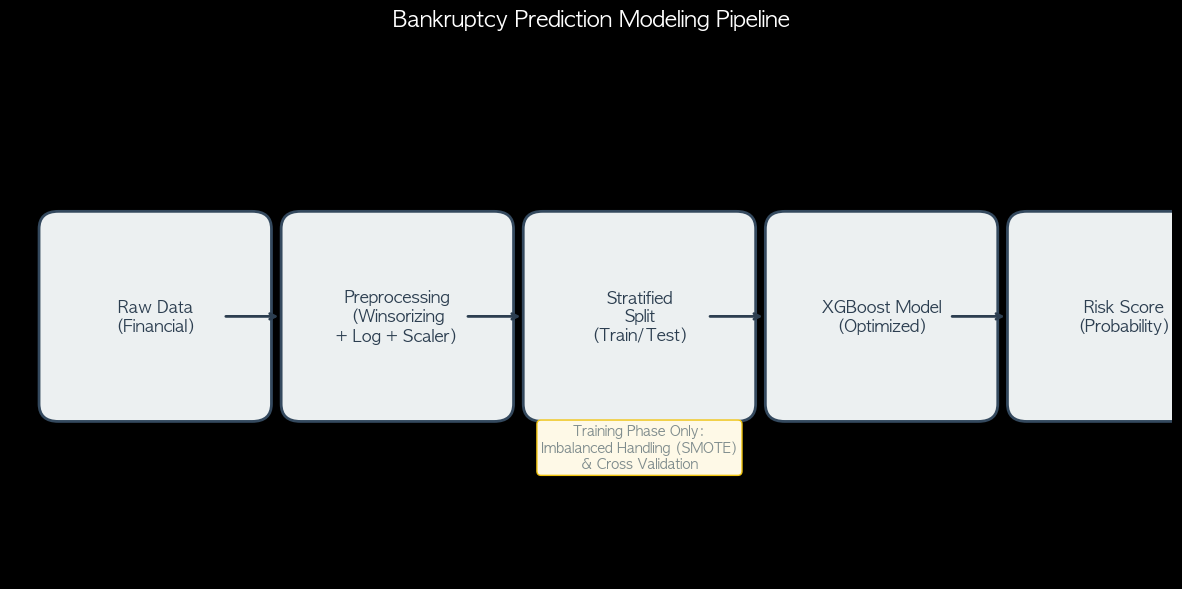

In [15]:
def plot_pipeline_flowchart():
    fig, ax = plt.subplots(figsize=(12, 6))
    ax.set_xlim(0, 12)
    ax.set_ylim(0, 6)
    ax.axis('off')

    # 스타일 정의
    box_style = dict(boxstyle="round,pad=0.5", fc="white", ec="#2C3E50", lw=2)
    arrow_style = dict(arrowstyle="->", color="#2C3E50", lw=2)
    font_style = dict(ha='center', va='center', fontsize=12, fontweight='bold', color='#2C3E50')

    # 노드 위치 및 텍스트 정의
    nodes = {
        'Data': (1.5, 3, "Raw Data\n(Financial)"),
        'Pre': (4, 3, "Preprocessing\n(Winsorizing\n+ Log + Scaler)"),
        'Split': (6.5, 3, "Stratified\nSplit\n(Train/Test)"),
        'Model': (9, 3, "XGBoost Model\n(Optimized)"),
        'Output': (11.5, 3, "Risk Score\n(Probability)")
    }

    # 노드 그리기
    for key, (x, y, text) in nodes.items():
        # 박스
        ax.add_patch(patches.FancyBboxPatch((x-1, y-1), 2, 2, boxstyle="round,pad=0.2", 
                                            fc="#ECF0F1", ec="#34495E", lw=2))
        # 텍스트
        ax.text(x, y, text, **font_style)

    # 화살표 그리기
    ax.annotate("", xy=(2.8, 3), xytext=(2.2, 3), arrowprops=arrow_style) # Data -> Pre
    ax.annotate("", xy=(5.3, 3), xytext=(4.7, 3), arrowprops=arrow_style) # Pre -> Split
    ax.annotate("", xy=(7.8, 3), xytext=(7.2, 3), arrowprops=arrow_style) # Split -> Model
    ax.annotate("", xy=(10.3, 3), xytext=(9.7, 3), arrowprops=arrow_style) # Model -> Output

    # 하단 주석 (SMOTE 등)
    ax.text(6.5, 1.5, "Training Phase Only:\nImbalanced Handling (SMOTE)\n& Cross Validation", 
            ha='center', va='center', fontsize=10, color='#7F8C8D', style='italic',
            bbox=dict(boxstyle="round", fc="#FEF9E7", ec="#F1C40F"))

    plt.title("Bankruptcy Prediction Modeling Pipeline", fontsize=16, fontweight='bold', pad=20)
    plt.tight_layout()
    plt.show()

plot_pipeline_flowchart()

In [16]:
if hasattr(final_model, 'named_steps'):
    pure_model = final_model.named_steps['classifier']
else:
    pure_model = final_model

joblib.dump(pure_model, '../data/processed/final_xgb_model_only.pkl')

['../data/processed/final_xgb_model_only.pkl']